In [1]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from Pytorch import *
from utils import train_val_split, LrScheduler, EarlyStopping, SaveBestModel

%matplotlib inline
plt.rcParams["figure.figsize"] = [7, 4]
plt.rcParams["image.interpolation"] = 'nearest'
plt.rcParams["image.cmap"] = 'gray'

cuda


In [2]:
# hyper parameters
batch_size = 80

transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(), 
                                transforms.Normalize(0.5, 0.5, 0.5)])

In [3]:
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_dataset, validation_dataset = train_val_split(dataset, 0.8)

train_loader  = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader  = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)

test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print(f"Train length : {len(train_dataset)}, \tValidation length : {len(validation_dataset)}, \tTest length: {len(test_dataset)}")

Train length : 48000, 	Validation length : 12000, 	Test length: 10000


In [4]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images.shape, labels.shape

(torch.Size([80, 1, 28, 28]), torch.Size([80]))

In [5]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images.shape, labels.shape

(torch.Size([80, 1, 28, 28]), torch.Size([80]))

torch.Size([80, 1, 28, 28])


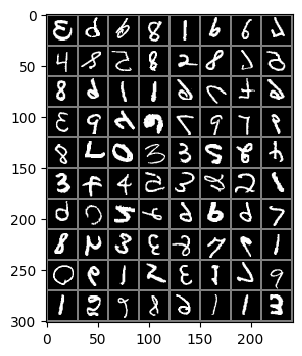

In [6]:
def img_show(img):
    img = (img / 2) + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, axes=(1,2,0)))
    
img_show(torchvision.utils.make_grid(images))
print(images.shape)

In [7]:
def fit(model, train_loader, optimizer, criterion):
    train_running_loss = 0.0
    train_running_correct = 0
    total = 0
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader), leave=True) 
    for batch_idx, (images, labels) in prog_bar:
        # load data and labels to device
        images, labels = images.to(device), labels.to(device)
        # total number of labels
        total += labels.size(0)
        # set optimizer to zero
        optimizer.zero_grad()
        # predict the labels
        outputs = model(images)
        # calculate the loss
        batch_loss = criterion(outputs, labels)
        # backward propagation
        batch_loss.backward()
        # optimizer step
        optimizer.step()
        train_running_loss += batch_loss.item()
        _, y_pred = torch.max(outputs, axis=1)
        train_running_correct += (y_pred == labels).sum().item()
        
        prog_bar.set_description(f"Batch : {batch_idx+1}/{len(train_loader)}")
        prog_bar.set_postfix(loss=batch_loss.item())
    
    train_loss = train_running_loss / len(train_loader)
    train_acc = 100. * train_running_correct / total
        
    return train_loss, train_acc



def validate(model, val_loader, criterion):
    running_val_loss, running_val_acc = 0.0, 0
    total = 0
    
    prog_bar = tqdm(enumerate(val_loader), total=(len(val_loader)), leave=True)
    with torch.no_grad():
        for batch_idx, (images, labels) in prog_bar:
            # Shift the images and labels to device
            images, labels = images.to(device), labels.to(device)
            total += len(labels)
            # predict the outputs
            outputs = model(images)
            # calculate the loss
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
            #calculate accuracy
            _, y_pred = torch.max(outputs, dim=1)
            running_val_acc += (y_pred == labels).sum().item()
            
            prog_bar.set_description(f"Batch : {batch_idx+1}/{len(val_loader)}")
            prog_bar.set_postfix(loss=val_loss.item())
            
    total_val_loss = running_val_loss / len(val_loader)
    total_val_acc  = 100 * running_val_acc / total
    
    return total_val_loss, total_val_acc



def model_train(model, train_loader, val_loader, num_epochs, learning_rate, criterion, early_stop=False):
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    
    model = ConvNet().to(device)
    save_best_model = SaveBestModel()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = LrScheduler(optimizer)
    if early_stop:
        early_stopping = EarlyStopping(patience=5)
    
    for epoch in range(num_epochs):
        train_loss, train_acc = fit(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        train_loss_list.append(train_loss), train_acc_list.append(train_acc)
        val_loss_list.append(val_loss), val_acc_list.append(val_acc)
        
        lr_scheduler(val_loss)
        lr = optimizer.param_groups[0]["lr"]
        
        print(f"""Traing Set :\nEpoch :{epoch+1}/{num_epochs}, \tloss : {train_loss:.3f}, \
                \tAccuracy:{train_acc:.2f}%, \tLearning Rate : {lr}""")
        print(f"""Validation Set :\nEpoch :{epoch+1}/{num_epochs}, \tLoss : {val_loss:.3f},\t Accuracy :  {val_acc:.2f}%""")
        
        save_best_model(val_loss, epoch, model, optimizer, criterion)
        
        if early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break
        
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [8]:
model = ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
model, train_loss, train_acc, val_loss, val_acc = model_train(model, train_loader, validation_loader, 10, 0.03, criterion, early_stop=True)

Batch : 150/150: 100%|███████████████████████████████████████████████████| 150/150 [00:07<00:00, 20.87it/s, loss=0.624]


Traing Set :
Epoch :1/10, 	loss : 0.630,                 	Accuracy:78.71%, 	Learning Rate : 0.03
Validation Set :
Epoch :1/10, 	Loss : 0.570,	 Accuracy :  81.17%

Best validation loss: 0.5699016219377517

Saving best model for epoch: 1



Batch : 150/150: 100%|███████████████████████████████████████████████████| 150/150 [00:07<00:00, 21.29it/s, loss=0.433]


Traing Set :
Epoch :2/10, 	loss : 0.332,                 	Accuracy:89.76%, 	Learning Rate : 0.03
Validation Set :
Epoch :2/10, 	Loss : 0.242,	 Accuracy :  92.44%

Best validation loss: 0.24238106215993563

Saving best model for epoch: 2



Batch : 150/150: 100%|██████████████████████████████████████████████████| 150/150 [00:07<00:00, 19.62it/s, loss=0.0888]


Traing Set :
Epoch :3/10, 	loss : 0.229,                 	Accuracy:93.05%, 	Learning Rate : 0.03
Validation Set :
Epoch :3/10, 	Loss : 0.201,	 Accuracy :  93.85%

Best validation loss: 0.2012811978161335

Saving best model for epoch: 3



Batch : 150/150: 100%|██████████████████████████████████████████████████| 150/150 [00:08<00:00, 18.40it/s, loss=0.0641]


Traing Set :
Epoch :4/10, 	loss : 0.196,                 	Accuracy:93.98%, 	Learning Rate : 0.03
Validation Set :
Epoch :4/10, 	Loss : 0.185,	 Accuracy :  94.36%

Best validation loss: 0.18511052742600442

Saving best model for epoch: 4



Batch : 150/150: 100%|███████████████████████████████████████████████████| 150/150 [00:09<00:00, 16.50it/s, loss=0.267]


Traing Set :
Epoch :5/10, 	loss : 0.177,                 	Accuracy:94.65%, 	Learning Rate : 0.03
Validation Set :
Epoch :5/10, 	Loss : 0.172,	 Accuracy :  94.78%

Best validation loss: 0.17153477274502318

Saving best model for epoch: 5



Batch : 150/150: 100%|███████████████████████████████████████████████████| 150/150 [00:09<00:00, 15.39it/s, loss=0.264]


Traing Set :
Epoch :6/10, 	loss : 0.162,                 	Accuracy:95.17%, 	Learning Rate : 0.03
Validation Set :
Epoch :6/10, 	Loss : 0.166,	 Accuracy :  94.97%

Best validation loss: 0.16613050426046053

Saving best model for epoch: 6



Batch : 150/150: 100%|██████████████████████████████████████████████████| 150/150 [00:08<00:00, 17.55it/s, loss=0.0597]


Traing Set :
Epoch :7/10, 	loss : 0.156,                 	Accuracy:95.39%, 	Learning Rate : 0.03
Validation Set :
Epoch :7/10, 	Loss : 0.152,	 Accuracy :  95.42%

Best validation loss: 0.15225973141690094

Saving best model for epoch: 7



Batch : 150/150: 100%|███████████████████████████████████████████████████| 150/150 [00:10<00:00, 14.52it/s, loss=0.148]


Traing Set :
Epoch :8/10, 	loss : 0.144,                 	Accuracy:95.81%, 	Learning Rate : 0.03
Validation Set :
Epoch :8/10, 	Loss : 0.140,	 Accuracy :  95.94%

Best validation loss: 0.13969569846366842

Saving best model for epoch: 8



Batch : 150/150: 100%|██████████████████████████████████████████████████| 150/150 [00:08<00:00, 17.84it/s, loss=0.0379]


Traing Set :
Epoch :9/10, 	loss : 0.138,                 	Accuracy:95.86%, 	Learning Rate : 0.03
Validation Set :
Epoch :9/10, 	Loss : 0.138,	 Accuracy :  96.01%

Best validation loss: 0.13816801227629186

Saving best model for epoch: 9



Batch : 150/150: 100%|██████████████████████████████████████████████████| 150/150 [00:08<00:00, 17.42it/s, loss=0.0602]


Traing Set :
Epoch :10/10, 	loss : 0.133,                 	Accuracy:96.12%, 	Learning Rate : 0.03
Validation Set :
Epoch :10/10, 	Loss : 0.123,	 Accuracy :  96.53%

Best validation loss: 0.12330873112815122

Saving best model for epoch: 10



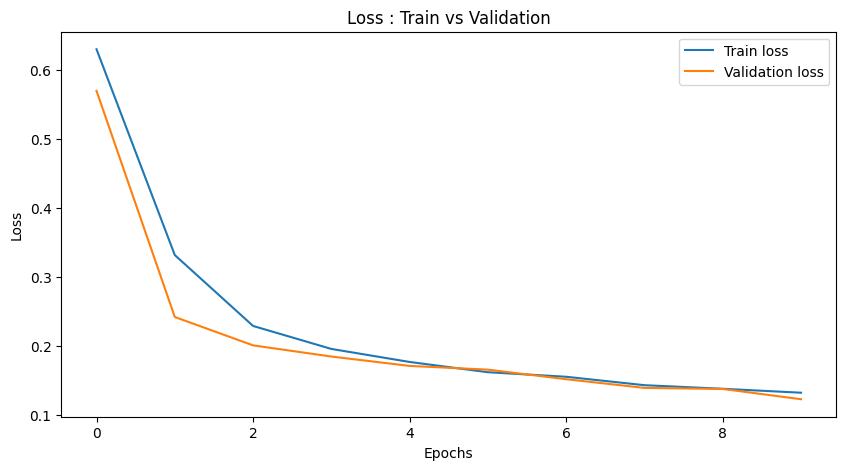

In [10]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Validation loss")
plt.title("Loss : Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

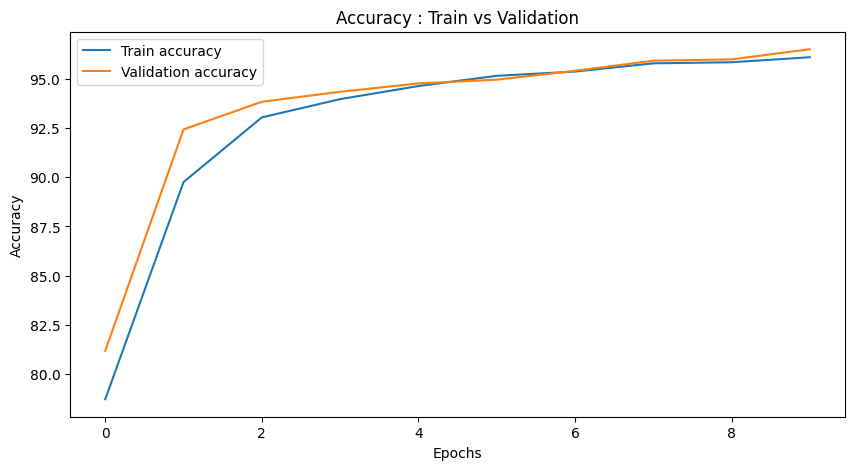

In [11]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_acc, label="Train accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.title("Accuracy : Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [12]:
n_correct = 0
n_samples = 0
n_class_correct = [0 for _ in range(10)]
n_class_samples = [0 for _ in range(10)]
tot_running_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss = criterion(outputs, labels)
        tot_running_loss += test_loss
        _, predicted = torch.max(outputs, dim=1)
        n_samples += len(labels) 
        n_correct += (predicted == labels).sum().item()
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    tot_loss = tot_running_loss / len(test_loader)
    acc = 100.0 * (n_correct / n_samples)
    print(f"Loss: {tot_loss:.3f},\t Accuracy of the network:  {acc:.3f}%")
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f"Accuracy of {test_dataset.classes[i]}: {acc}%")

Loss: 0.132,	 Accuracy of the network:  96.390%
Accuracy of 0 - zero: 98.9795918367347%
Accuracy of 1 - one: 98.8546255506608%
Accuracy of 2 - two: 91.27906976744185%
Accuracy of 3 - three: 97.82178217821782%
Accuracy of 4 - four: 98.67617107942974%
Accuracy of 5 - five: 94.73094170403587%
Accuracy of 6 - six: 94.258872651357%
Accuracy of 7 - seven: 97.95719844357977%
Accuracy of 8 - eight: 98.870636550308%
Accuracy of 9 - nine: 92.17046580773042%


In [13]:
FILE = "model_mnist_digit.pth"
torch.save(model, FILE)

In [14]:
PATH = "model_mnist_digit_preferred.pth"
torch.save(model.state_dict(), PATH)